## Part 2.1: Creating and analyzing your own SMLM data


For this example we compare 3D-DAOSTORM in single versus multi-emitter fitting mode, but the approach can of course be used to test the performance of any localization algorithm.

Note that the results are not directly comparable with the results of Cohen et al. as among other differences we're using a Gaussian PSF model instead of an Airy PSF model.

References:
* [Cohen et al, Nature Communications, 2019](https://doi.org/10.1038/s41467-019-08689-x).


First analyze in single fitter mode.

Repeat analysis in multi-fitter mode.

In [14]:
import scipy
import scipy.spatial


# Average PCF calculation for a movie.
def AveragePCF(h5_name):
    cnts = 0
    r = None
    pcf = None
    with saH5Py.SAH5Reader(h5_name) as h5:
        for [fnum, locs] in h5.localizationsIterator(fields = ["x", "y"]):
            if((fnum%2)==0):
                print("Calculating PCF for", fnum)
            [r, tmp] = PCF(locs)
            if pcf is None:
                pcf = tmp
            else:
                pcf += tmp
            cnts += 1.0
    print()
    pcf = pcf/cnts
    return [r, pcf]
    
    
# PCF function calculation.
def PCF(locs):
    
    # Maximum distance for PCF calculation, this should be an integer.
    max_dist = 30  

    # Create a KDTree to make this more efficient.
    kd = scipy.spatial.KDTree(numpy.stack((locs["x"], locs["y"]), axis = -1))
    
    # Ignore localizations near the edges.
    sx = max_dist + 2
    ex = im_size - max_dist - 3
    mask = (locs["x"] > sx) & (locs["x"] < ex) & (locs["y"] > sx) & (locs["y"] < ex)
    
    n_bins = 10*max_dist
    d_hist = numpy.zeros(n_bins)
    for i in range(mask.size):

        # Skip localizations that are near the edge.
        if not(mask[i]):
            continue
            
        pnt = numpy.array([locs["x"][i], locs["y"][i]])
        [dist, index] = kd.query(pnt, k = None, distance_upper_bound = max_dist)
        [hist, edges] = numpy.histogram(dist, bins = n_bins, range = (0, max_dist), density = False)
        d_hist += hist
        
    # Normalize.
    r = 2.0*numpy.pi*numpy.arange(0.0,max_dist,0.1)*0.1
    d_hist = d_hist/numpy.count_nonzero(mask)
    d_hist = d_hist[1:]/r[1:]
    
    density = numpy.count_nonzero(mask)/((ex-sx)*(ex-sx))
    d_hist = d_hist/density
    
    # r in microns.
    r = r * 1.0e-3 * pixel_size
    
    return [r[1:], d_hist]



In [16]:
# Ground truth PCF.
[r, gt_pcf] = AveragePCF("tests/test_ref.hdf5")

Calculating PCF for 0
Calculating PCF for 2
Calculating PCF for 4
Calculating PCF for 6
Calculating PCF for 8



In [17]:
# Single fitter PCF. 
[r, se_pcf] = AveragePCF("tests/test_se.hdf5")

Calculating PCF for 0
Calculating PCF for 2
Calculating PCF for 4
Calculating PCF for 6
Calculating PCF for 8



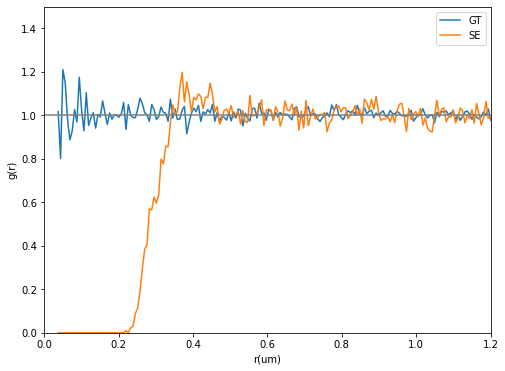

In [18]:
import matplotlib
import matplotlib.pyplot as pyplot

start = 5
pyplot.figure(figsize = (8,6))
pyplot.plot(r[start:], gt_pcf[start:], label = "GT")
pyplot.plot(r[start:], se_pcf[start:], label = "SE")
pyplot.plot([-0.1,1.3],[1.0,1.0], color = "gray")
pyplot.legend()
pyplot.xlabel("r(um)")
pyplot.ylabel("g(r)")
pyplot.xlim(0,1.2)
pyplot.ylim(0,1.5)
pyplot.show()